In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

# Données synthétiques

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [780]:
import itertools
mu = 1.0
tmax = 20.0
alpha = 0.2
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 25.000


In [781]:
n_traj = 10
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

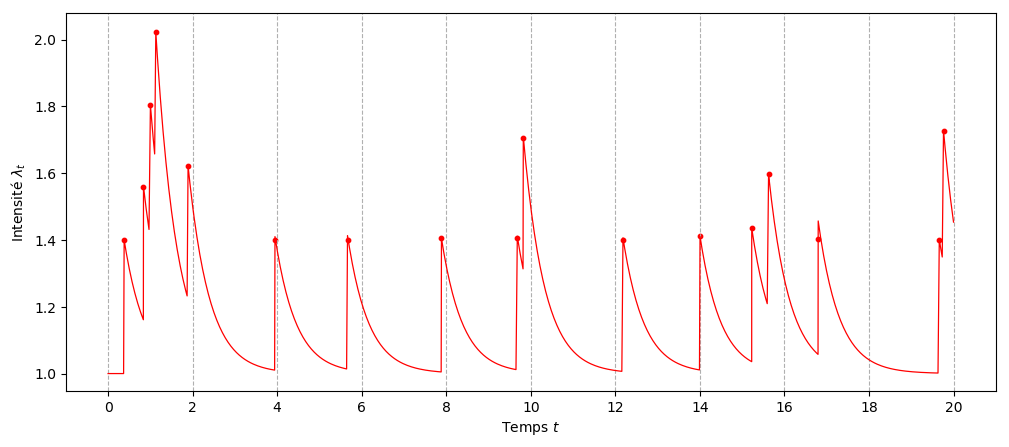

In [782]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [783]:
input_size = max(s.shape[0] for s in sample_trajectories)
print("Input size (max. trajectory length): %d" % input_size)
length_array = [s.shape[0] for s in sample_trajectories]
data_array = np.stack([np.pad(s[:,0], ((0, input_size - s.shape[0])), 'constant') for s in sample_trajectories])
data_array = data_array.transpose()
data_tensor = torch.from_numpy(data_array).to(torch.float32)

Input size (max. trajectory length): 33


In [784]:
length_array

[17, 23, 26, 33, 20, 29, 26, 28, 18, 26]

The first dimension is for time, the second for the sample.

## Neural net

In [785]:
import torch
import torch.nn as nn
import torch.nn.functional as tnf
from torch import optim

In [786]:
device = torch.device("cpu")
print(device)

cpu


In [787]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [791]:
from model import NeuralCTLSTM

In [789]:
nhlstm = NeuralCTLSTM(10)
optimizer = optim.SGD(nhlstm.parameters(), lr=0.0001)

# We use mini-batches to train on our data
BATCH_SIZE = 10
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(1))
split_into_batches = data_tensor.split(BATCH_SIZE, dim=1)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

Batch size: 10
Training sample size: 10
No. of batches: 1


In [790]:
def train(num_of_batches):
    nhlstm.zero_grad()
    for i in range(num_of_batches):
        event_times = split_into_batches[i]
        feed_data = event_times[:-1] - event_times[1:] # transform into inter-arrival times
        print("Running batch %d, size %d." % (i, feed_data.size(1)), end=' ')
        output_hist = []
        hidden_hist = []
        cell_hist = []
        cell_target_hist = []
        decay_hist = []
        nhlstm.init_hidden(feed_data.size(1))
        for i in range(feed_data.size(0)):
            output, hidden, ct, cbar, decay_t = nhlstm(feed_data[i])
            output_hist.append(output)
            hidden_hist.append(hidden)
            cell_hist.append(ct)
            cell_target_hist.append(cbar)
            decay_hist.append(decay_t)
        output_hist = torch.stack(output_hist)
        hidden_hist = torch.stack(hidden_hist)
        cell_hist = torch.stack(cell_hist)
        cell_target_hist = torch.stack(cell_target_hist)
        decay_hist = torch.stack(decay_hist)

        loss = nhlstm.likelihood(event_times, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
        print("Loss: %.5f" % loss.item())
        loss.backward()  # compute the gradients
        optimizer.step() # do a step of the SGD algorithm

train(1)

Running batch 0, size 10. inter_times shape: torch.Size([32, 10])
event intensities shape torch.Size([32, 1, 10])
first_sum shape torch.Size([1, 10])
mask dim torch.Size([33, 10])
tensor([[ 0,  1,  1,  1,  1,  0,  0,  0,  0,  0],
        [ 0,  2,  2,  2,  2,  1,  0,  0,  1,  0],
        [ 0,  3,  2,  3,  3,  2,  0,  0,  2,  0],
        [ 1,  4,  2,  4,  4,  3,  0,  0,  2,  0],
        [ 2,  5,  2,  5,  5,  4,  0,  1,  2,  0],
        [ 2,  6,  3,  6,  6,  5,  0,  1,  2,  0],
        [ 2,  7,  3,  7,  7,  6,  0,  1,  2,  0],
        [ 2,  7,  3,  8,  8,  7,  0,  1,  2,  0],
        [ 2,  7,  3,  9,  9,  8,  0,  1,  2,  0],
        [ 2,  7,  4, 10, 10,  9,  0,  1,  2,  0],
        [ 2,  8,  4, 11, 10, 10,  0,  1,  2,  0],
        [ 2,  9,  4, 12, 10, 11,  0,  1,  2,  0],
        [ 2, 10,  4, 13, 10, 12,  0,  1,  2,  0],
        [ 2, 11,  4, 13, 10, 13,  0,  1,  2,  0],
        [ 2, 11,  4, 13, 10, 14,  0,  1,  2,  0],
        [ 2, 11,  4, 13, 10, 15,  0,  1,  2,  0],
        [ 2, 11,  4,

RuntimeError: t() expects a 2D tensor, but self is 3D